# XGBoost Training, Testing, and Verification

This notebook trains an XGBoost model for CAN bus attack detection, tests it on unlabeled data, and verifies performance. It performs:

1. **Train Model**: Load `can_bus_combined.csv`, train XGBoost with class weights, and save the model.
2. **Test on Unlabeled Data**: Process `unlabeled_data.log`, compute features, predict labels, and save predictions.
3. **Verify Performance**: Evaluate on labeled test set, analyze unlabeled predictions, and visualize results.

**Input Files**:
- Labeled: `C:\Users\pc\OneDrive\Bureau\VS_code_Projects\MLproject_Predictive_Maintenance_for_Vehicles_Using_CAN_Bus_Data\dataSet\processed\generated.csv`
- Unlabeled: `C:\Users\pc\OneDrive\Bureau\VS_code_Projects\MLproject_Predictive_Maintenance_for_Vehicles_Using_CAN_Bus_Data\dataSet\raw\dos\dosattack.log`

**Output Files**:
- Model: `C:\Users\pc\OneDrive\Bureau\VS_code_Projects\MLproject_Predictive_Maintenance_for_Vehicles_Using_CAN_Bus_Data\models\xgboost_model.json`
- Predictions: `C:\Users\pc\OneDrive\Images\Bureau\VS_code_Projects\MLproject_Predictive_Maintenance_for_Vehicles_Using_CAN_Bus_Data\dataSet\raw\unlabeled_predictions.csv`

## Step 1: Import Libraries

Import libraries for data processing, model training, feature computation, and visualization.

In [1]:
import csv
import pandas as pd
import numpy as np
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from pathlib import Path
import sys
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
%matplotlib inline

## Step 2: Define Feature Computation Functions

Reuse functions from `can_bus_processing.ipynb` to process unlabeled data and compute features.

In [2]:
def generate_random_payload(length=16):
    return ''.join(random.choice(string.hexdigits.upper()) for _ in range(length))

def compute_payload_entropy(payload):
    if not payload:
        return 0.0
    bytes_array = [int(payload[i:i+2], 16) for i in range(0, len(payload), 2)]
    value_counts = pd.Series(bytes_array).value_counts()
    probs = value_counts / len(bytes_array)
    return entropy(probs, base=2)

def compute_payload_decimal(payload):
    try:
        return int(payload, 16)
    except ValueError:
        return 0

def compute_window_count(df, window_size=5.0):
    df = df.copy()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    window_counts = []
    for can_id in tqdm(df['CAN_ID'].unique(), desc="Processing CAN_IDs"):
        can_id_df = df[df['CAN_ID'] == can_id][['Timestamp']].copy()
        can_id_df['Dummy'] = 1
        can_id_df.set_index('Timestamp', inplace=True)
        can_id_df['CAN_ID_Window_Count'] = (
            can_id_df['Dummy']
            .rolling(window=f'{window_size}s', closed='both')
            .count()
            .astype(int)
        )
        can_id_df.reset_index(inplace=True)
        can_id_df['CAN_ID'] = can_id
        window_counts.append(can_id_df[['Timestamp', 'CAN_ID', 'CAN_ID_Window_Count']])
    result = pd.concat(window_counts)
    result['Timestamp'] = result['Timestamp'].astype(int) / 10**9
    return result

def compute_suspension_indicator(df, threshold=2.0, window=0.5):
    df = df.sort_values('Timestamp')
    indicators = np.zeros(len(df))
    total_can_ids = len(df['CAN_ID'].unique())
    timestamps = df['Timestamp'].to_numpy()
    inter_arrivals = df['CAN_ID_Inter_Arrival'].to_numpy()
    can_ids = df['CAN_ID'].to_numpy()
    for i in tqdm(range(len(df)), desc="Processing messages"):
        timestamp = timestamps[i]
        mask = (timestamps >= timestamp - window) & (timestamps <= timestamp + window) & (inter_arrivals > threshold)
        affected_can_ids = len(np.unique(can_ids[mask]))
        indicators[i] = affected_can_ids / total_can_ids if total_can_ids > 0 else 0.0
    return indicators

def process_unlabeled_data(input_file_path, normal_stats):
    # Read unlabeled log file
    messages = []
    total_lines = sum(1 for _ in open(input_file_path, 'r', encoding='utf-8'))
    print(f"Reading unlabeled file with {total_lines} lines...")
    with open(input_file_path, 'r', encoding='utf-8') as log_file:
        for line in tqdm(log_file, total=total_lines, desc="Parsing lines"):
            line = line.strip()
            if not line or not line.startswith('('):
                continue
            try:
                timestamp_end = line.find(')')
                timestamp = float(line[1:timestamp_end])
                remaining = line[timestamp_end+1:].strip()
                parts = remaining.split(maxsplit=1)
                if len(parts) == 2:
                    interface = parts[0]
                    can_data = parts[1]
                    if '#' in can_data:
                        can_id, payload = can_data.split('#', 1)
                        messages.append({
                            'Timestamp': timestamp,
                            'Interface': interface,
                            'CAN_ID': can_id,
                            'Payload': payload
                        })
            except:
                continue
    if not messages:
        print("No valid messages found in the unlabeled log file.")
        sys.exit(1)

    df = pd.DataFrame(messages)
    print(f"Loaded {len(df)} messages into DataFrame.")

    # Compute features
    df = df.sort_values('Timestamp').reset_index(drop=True)
    df['CAN_ID_Inter_Arrival'] = df.groupby('CAN_ID')['Timestamp'].diff().fillna(0.010)
    window_counts = compute_window_count(df)
    df = df.merge(window_counts, on=['Timestamp', 'CAN_ID'], how='left')
    df['CAN_ID_Window_Count'] = df['CAN_ID_Window_Count'].fillna(0).astype(int)
    df['Payload_Entropy'] = df['Payload'].apply(compute_payload_entropy)
    df['Payload_Decimal'] = df['Payload'].apply(compute_payload_decimal)
    max_decimal = 2**64 - 1
    df['Norm_Payload_Decimal'] = df['Payload_Decimal'] / max_decimal
    max_entropy = 8.0
    df['Norm_Payload_Entropy'] = df['Payload_Entropy'] / max_entropy
    df['Suspension_Indicator'] = compute_suspension_indicator(df)

    # Normalize features using training normal_stats
    def normalize_features(row, stats_df):
        can_id = row['CAN_ID']
        stats = stats_df[stats_df['CAN_ID'] == can_id]
        if not stats.empty:
            norm_inter_arrival = row['CAN_ID_Inter_Arrival'] / stats['Mean_Inter_Arrival'].iloc[0] if stats['Mean_Inter_Arrival'].iloc[0] != 0 else 1.0
            norm_window_count = row['CAN_ID_Window_Count'] / stats['Mean_Window_Count'].iloc[0] if stats['Mean_Window_Count'].iloc[0] != 0 else 1.0
        else:
            norm_inter_arrival = 1.0
            norm_window_count = 1.0
        return pd.Series({'Norm_Inter_Arrival': norm_inter_arrival, 'Norm_Window_Count': norm_window_count})

    normalized_features = df.apply(normalize_features, axis=1, args=(normal_stats,))
    df = pd.concat([df, normalized_features], axis=1)
    return df

## Step 3: Train the Model

Load labeled data, split, train XGBoost, and save the model.

In [3]:
# Define paths
labeled_data_path = r"C:\Users\pc\OneDrive\Bureau\VS_code_Projects\MLproject_Predictive_Maintenance_for_Vehicles_Using_CAN_Bus_Data\dataSet\processed\generated.csv"
model_path = r"C:\Users\pc\OneDrive\Bureau\VS_code_Projects\MLproject_Predictive_Maintenance_for_Vehicles_Using_CAN_Bus_Data\models\xgboost_model.json"

# Load labeled data
print("Loading labeled data...")
df = pd.read_csv(labeled_data_path)
print(f"Loaded {len(df)} rows.")

# Verify labels
print("\nLabel Counts:")
print(df['Label'].value_counts())

# Features and target
features = [
    'CAN_ID_Inter_Arrival', 'CAN_ID_Window_Count', 'Payload_Entropy',
    'Norm_Inter_Arrival', 'Norm_Window_Count', 'Norm_Payload_Entropy',
    'Norm_Payload_Decimal', 'Suspension_Indicator'
]
X = df[features]
y = df['Label']

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)  # 0.1765 ~ 15% of 85%
print(f"\nTrain: {len(X_train)} rows, Validation: {len(X_val)} rows, Test: {len(X_test)} rows")

# Compute class weights
train_label_counts = y_train.value_counts().to_dict()
n_samples = len(y_train)
n_classes = len(np.unique(y_train))
class_weights = {i: n_samples / (n_classes * train_label_counts.get(i, 1)) for i in range(4)}
sample_weights = y_train.map(class_weights)

# Initialize and train model
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='mlogloss',
    random_state=42
)

print("\nTraining XGBoost model...")
model.fit(X_train, y_train, sample_weight=sample_weights, verbose=True)

# Save model
model.save_model(model_path)
print(f"Model saved to {model_path}")

# Compute normal statistics for normalization
normal_df = df[df['Label'] == 0][['CAN_ID', 'CAN_ID_Inter_Arrival', 'CAN_ID_Window_Count']]
normal_stats = normal_df.groupby('CAN_ID').agg({
    'CAN_ID_Inter_Arrival': 'mean',
    'CAN_ID_Window_Count': 'mean'
}).reset_index()
normal_stats.columns = ['CAN_ID', 'Mean_Inter_Arrival', 'Mean_Window_Count']

Loading labeled data...
Loaded 413196 rows.

Label Counts:
Label
0    370916
1     39983
2      2222
3        75
Name: count, dtype: int64

Train: 289226 rows, Validation: 61990 rows, Test: 61980 rows

Training XGBoost model...
Model saved to C:\Users\pc\OneDrive\Bureau\VS_code_Projects\MLproject_Predictive_Maintenance_for_Vehicles_Using_CAN_Bus_Data\models\xgboost_model.json


## Step 4: Evaluate on Labeled Test Set

Assess model performance on the labeled test set.


Classification Report on Labeled Test Set:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     55638
         DoS       1.00      1.00      1.00      5998
     Fuzzing       0.99      0.99      0.99       333
  Suspension       1.00      1.00      1.00        11

    accuracy                           1.00     61980
   macro avg       1.00      1.00      1.00     61980
weighted avg       1.00      1.00      1.00     61980



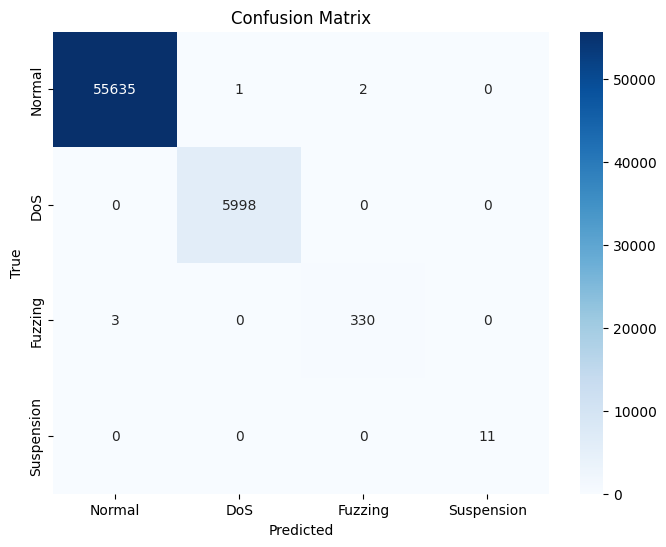

<Figure size 1000x600 with 0 Axes>

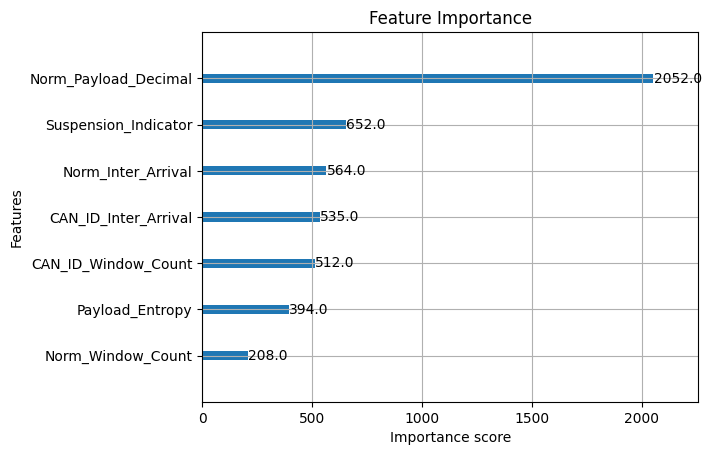

In [4]:
# Predict on test set
y_pred = model.predict(X_test)
unique_classes = np.unique(y_test)
target_names = ['Normal', 'DoS', 'Fuzzing', 'Suspension']

# Classification report
print("\nClassification Report on Labeled Test Set:")
print(classification_report(y_test, y_pred, labels=unique_classes, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=8)
plt.title('Feature Importance')
plt.show()

## Step 5: Test on Unlabeled Data

Process unlabeled data, predict labels, and save results.

In [6]:
# Define unlabeled data path
unlabeled_data_path = r"C:\Users\pc\OneDrive\Bureau\VS_code_Projects\MLproject_Predictive_Maintenance_for_Vehicles_Using_CAN_Bus_Data\dataSet\raw\dos\dosattack.log"
predictions_path = r"C:\Users\pc\OneDrive\Images\Bureau\VS_code_Projects\MLproject_Predictive_Maintenance_for_Vehicles_Using_CAN_Bus_Data\dataSet\raw\unlabeled_predictions.csv"

# Process unlabeled data
print("\nProcessing unlabeled data...")
unlabeled_df = process_unlabeled_data(unlabeled_data_path, normal_stats)

# Predict labels
X_unlabeled = unlabeled_df[features]
unlabeled_df['Predicted_Label'] = model.predict(X_unlabeled)

# Save predictions
unlabeled_df.to_csv(predictions_path, index=False)
print(f"Predictions saved to {predictions_path}")

# Summary of predictions
print("\nPrediction Counts on Unlabeled Data:")
print(unlabeled_df['Predicted_Label'].value_counts().rename(index={0: 'Normal', 1: 'DoS', 2: 'Fuzzing', 3: 'Suspension'}))

# Feature distributions by predicted label
print("\nFeature Distributions by Predicted Label:")
for label in range(4):
    label_df = unlabeled_df[unlabeled_df['Predicted_Label'] == label]
    if not label_df.empty:
        print(f"Predicted Label {label} ({['Normal', 'DoS', 'Fuzzing', 'Suspension'][label]}):")
        print(label_df[['CAN_ID_Inter_Arrival', 'CAN_ID_Window_Count', 'Payload_Entropy', 'Suspension_Indicator']].describe())


Processing unlabeled data...
Reading unlabeled file with 141927 lines...


Parsing lines: 100%|██████████| 141927/141927 [00:00<00:00, 238370.96it/s]


Loaded 141927 messages into DataFrame.


Processing messages: 100%|██████████| 141927/141927 [00:40<00:00, 3536.11it/s]


Predictions saved to C:\Users\pc\OneDrive\Images\Bureau\VS_code_Projects\MLproject_Predictive_Maintenance_for_Vehicles_Using_CAN_Bus_Data\dataSet\raw\unlabeled_predictions.csv

Prediction Counts on Unlabeled Data:
Predicted_Label
Normal    101926
DoS        40001
Name: count, dtype: int64

Feature Distributions by Predicted Label:
Predicted Label 0 (Normal):
       CAN_ID_Inter_Arrival  CAN_ID_Window_Count  Payload_Entropy  \
count         101926.000000        101926.000000    101926.000000   
mean               0.044442           262.560770         1.885325   
std                0.249720           194.043203         1.003645   
min                0.001384             0.000000         0.000000   
25%                0.010023            51.000000         1.000000   
50%                0.019930           250.000000         2.321928   
75%                0.049640           500.000000         2.750000   
max               12.013576           502.000000         3.000000   

       Suspension

## Step 6: Verify Accuracy on Unlabeled Data

Since the data is unlabeled, verify predictions by checking feature patterns and optionally injecting synthetic attacks.

In [1]:
# Verify feature patterns
print("\nVerifying Unlabeled Predictions:")
expected_patterns = {
    'Normal': {'CAN_ID_Inter_Arrival': '<0.1s', 'Payload_Entropy': 'variable', 'Suspension_Indicator': '~0.0'},
    'DoS': {'CAN_ID_Inter_Arrival': '~0.00025s', 'CAN_ID_Window_Count': '>1000', 'Payload_Entropy': '0.0'},
    'Fuzzing': {'Payload_Entropy': '~7-8', 'CAN_ID_Inter_Arrival': '~0.01s'},
    'Suspension': {'CAN_ID_Inter_Arrival': '>2.0s', 'Suspension_Indicator': '~1.0', 'CAN_ID_Window_Count': '<10'}
}

for label, patterns in expected_patterns.items():
    print(f"\n{label} Expected Patterns: {patterns}")
    label_df = unlabeled_df[unlabeled_df['Predicted_Label'] == int(['Normal', 'DoS', 'Fuzzing', 'Suspension'].index(label))]
    if not label_df.empty:
        print(f"Actual Summary for Predicted {label}:")
        print(label_df[['CAN_ID_Inter_Arrival', 'CAN_ID_Window_Count', 'Payload_Entropy', 'Suspension_Indicator']].mean())

# Optional: Inject synthetic attacks for validation
print("\nInjecting synthetic attacks into a copy of unlabeled data for verification...")
test_df = unlabeled_df.copy()

# Inject DoS: 100 messages
dos_start = test_df['Timestamp'].max() + 1.0
dos_timestamps = np.arange(dos_start, dos_start + 0.025, 0.00025)[:100]
dos_df = pd.DataFrame({
    'Timestamp': dos_timestamps,
    'Interface': 'slcan0',
    'CAN_ID': '000',
    'Payload': '0000000000000000',
    'CAN_ID_Inter_Arrival': 0.00025,
    'CAN_ID_Window_Count': 100,
    'Payload_Entropy': 0.0,
    'Norm_Payload_Entropy': 0.0,
    'Payload_Decimal': 0,
    'Norm_Payload_Decimal': 0.0,
    'Suspension_Indicator': 0.0,
    'Norm_Inter_Arrival': 0.025,
    'Norm_Window_Count': 10.0
})

# Inject Fuzzing: 100 messages
fuzzing_start = dos_start + 1.0
fuzzing_timestamps = np.linspace(fuzzing_start, fuzzing_start + 1.0, 100)
fuzzing_df = pd.DataFrame({
    'Timestamp': fuzzing_timestamps,
    'Interface': 'slcan0',
    'CAN_ID': '18A',
    'Payload': [generate_random_payload() for _ in range(100)],
    'CAN_ID_Inter_Arrival': 0.01,
    'CAN_ID_Window_Count': 10,
    'Payload_Entropy': 7.5,
    'Norm_Payload_Entropy': 7.5 / 8.0,
    'Payload_Decimal': [int(generate_random_payload(), 16) for _ in range(100)],
    'Norm_Payload_Decimal': [int(generate_random_payload(), 16) / (2**64 - 1) for _ in range(100)],
    'Suspension_Indicator': 0.0,
    'Norm_Inter_Arrival': 1.0,
    'Norm_Window_Count': 1.0
})

# Inject Suspension: 100 messages
suspension_start = fuzzing_start + 1.0
suspension_timestamps = np.linspace(suspension_start, suspension_start + 1.0, 100)
suspension_df = pd.DataFrame({
    'Timestamp': suspension_timestamps,
    'Interface': 'slcan0',
    'CAN_ID': '2C6',
    'Payload': '0000000000000000',
    'CAN_ID_Inter_Arrival': 10.0,
    'CAN_ID_Window_Count': 1,
    'Payload_Entropy': 0.0,
    'Norm_Payload_Entropy': 0.0,
    'Payload_Decimal': 0,
    'Norm_Payload_Decimal': 0.0,
    'Suspension_Indicator': 1.0,
    'Norm_Inter_Arrival': 100.0,
    'Norm_Window_Count': 0.1
})

# Combine and predict
test_df = pd.concat([test_df, dos_df, fuzzing_df, suspension_df], ignore_index=True)
test_df['Predicted_Label'] = model.predict(test_df[features])

# Verify synthetic attack detection
print("\nSynthetic Attack Detection Results:")
synthetic_counts = test_df[test_df['Timestamp'] >= dos_start]['Predicted_Label'].value_counts().rename(index={0: 'Normal', 1: 'DoS', 2: 'Fuzzing', 3: 'Suspension'})
print(synthetic_counts)
print("\nExpected: ~100 DoS (1), ~100 Fuzzing (2), ~100 Suspension (3)")

# Sample of synthetic attack predictions
print("\nSample Synthetic Attack Predictions (first 5 per type):")
for label, name in enumerate(['Normal', 'DoS', 'Fuzzing', 'Suspension']):
    sample = test_df[(test_df['Timestamp'] >= dos_start) & (test_df['Predicted_Label'] == label)][['Timestamp', 'CAN_ID', 'Predicted_Label']].head()
    if not sample.empty:
        print(f"{name}:")
        print(sample)


Verifying Unlabeled Predictions:

Normal Expected Patterns: {'CAN_ID_Inter_Arrival': '<0.1s', 'Payload_Entropy': 'variable', 'Suspension_Indicator': '~0.0'}


NameError: name 'unlabeled_df' is not defined